In [394]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import project_env as pe
import sklearn as sklearn
import math
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from itertools import product
import error_analysis as ea
from sklearn.metrics import precision_recall_curve
%matplotlib inline

In [454]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')
test = pd.read_csv('test.csv')

# Target Variable

In [455]:
#target variable of rearrest in 5 years
X_train, y_train = pe.create_target(train, years = 5)
X_val, y_val = pe.create_target(val, years = 5)

X_test, y_test = pe.create_target(test, years = 5)

In [457]:
unique, counts = np.unique(y_train, return_counts = True)
percent = counts[1]/counts.sum()
print('Training: %s percent were rearrested.' %(percent*100))

unique, counts = np.unique(y_val, return_counts = True)
percent = counts[1]/counts.sum()
print('Test: %s percent were rearrested.' %(percent*100))


Training: 51.9046644379 percent were rearrested.
Test: 51.8282699654 percent were rearrested.


In [458]:
#remove non-feature columns
X_train=X_train.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)
X_val=X_val.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)

#Using year and month as predictive variables
X_train=X_train.drop(['ARREST_DATE', 'ARREST_DATE_y'], axis=1)
X_val=X_val.drop(['ARREST_DATE','ARREST_DATE_y'], axis=1)

In [459]:
#remove non-feature columns
X_test=X_test.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)

#Using year and month as predictive variables
X_test=X_test.drop(['ARREST_DATE', 'ARREST_DATE_y'], axis=1)

# Gradient Boosted Trees

### Default Parameters

In [222]:
gbt = GradientBoostingClassifier()
gbt = gbt.fit(X_train,y_train)

gbt_pred_train = gbt.predict(X_train)
gbt_pred_val = gbt.predict(X_val)

In [223]:
# gbt accuracy
gbt_accu_train = sklearn.metrics.accuracy_score(y_train,gbt_pred_train)
gbt_accu_test = sklearn.metrics.accuracy_score(y_val,gbt_pred_val)

print("Accuracy on Training Dataset: {}".format(gbt_accu_train))
print("Accuracy on Val Dataset: {}".format(gbt_accu_test))

Accuracy on Training Dataset: 0.7542471174182984
Accuracy on Val Dataset: 0.7505002728761142


In [224]:
gbt_precision = sklearn.metrics.precision_score(y_val,gbt_pred_val)
gbt_recall = sklearn.metrics.recall_score(y_val,gbt_pred_val)
gbt_f_score = sklearn.metrics.f1_score(y_val,gbt_pred_val)

print("Precision: {}".format(gbt_precision))
print("Recall: {}".format(gbt_recall))
print("F-Score: {}".format(gbt_f_score))

Precision: 0.7535610090955895
Recall: 0.7706212706212706
F-Score: 0.7619956616052062


In [225]:
#confusion matrix for val set
gbt_cm = sklearn.metrics.confusion_matrix(y_val,gbt_pred_val)
gbt_cm    #add cm.to_latex?

array([[3860, 1436],
       [1307, 4391]])

### Parameter Optimization

In [354]:
n_estimators = [100, 300, 500]
learning_rates = [0.05, 0.1, 0.5]
max_depths = [3,5,10]
min_samples_splits = [2,4,8]

In [355]:
model_specs = pd.DataFrame(list(product(n_estimators, learning_rates, max_depths, min_samples_splits)),\
             columns=['n_estimator', 'learning_rate', 'max_depth', 'min_samples_split'])

model_specs['ModelID'] = range(1, len(model_specs)+1)

model_specs['ModelID'] = 'Model' + model_specs['ModelID'].astype(str)

model_specs.head()

,n_estimator,learning_rate,max_depth,min_samples_split,ModelID
0,100,0.05,3,2,Model1
1,100,0.05,3,4,Model2
2,100,0.05,3,8,Model3
3,100,0.05,5,2,Model4
4,100,0.05,5,4,Model5


In [356]:
models = {}

for i in range(len(model_specs)):
    models[model_specs.iloc[i,:]['ModelID']] = \
    GradientBoostingClassifier(n_estimators = int(model_specs.iloc[i,:]['n_estimator']),\
                               learning_rate = float(model_specs.iloc[i,:]['learning_rate']),\
                               max_depth = int(model_specs.iloc[i,:]['max_depth']),\
                               min_samples_split = int(model_specs.iloc[i,:]['min_samples_split'])
                              )

In [357]:
models_fit = {k: v.fit(X_train,y_train) for k, v in models.items()} #run at 10:45pm

In [358]:
models_predict_val = {k: v.predict(X_val) for k, v in models_fit.items()}

In [359]:
models_predict_prob = {k: v.predict_proba(X_val) for k, v in models_fit.items()}

In [360]:
model_specs.index = model_specs['ModelID']

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'Val Accuracy'] = \
    sklearn.metrics.accuracy_score(y_val, models_predict_val[model_num])

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'Precision'] = \
    sklearn.metrics.precision_score(y_val, models_predict_val[model_num])

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'Recall'] = \
    sklearn.metrics.recall_score(y_val, models_predict_val[model_num])

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'F-Score'] = \
    sklearn.metrics.f1_score(y_val, models_predict_val[model_num])

In [361]:
#best model
model_specs.loc[model_specs['F-Score'].idxmax(axis=1),]

n_estimator               300
learning_rate             0.1
max_depth                   5
min_samples_split           4
ModelID               Model41
Val Accuracy         0.759232
Precision            0.761888
Recall                0.77887
F-Score              0.770286
Name: Model41, dtype: object

In [362]:
model_specs.to_csv('gbt_optimization_results.csv')

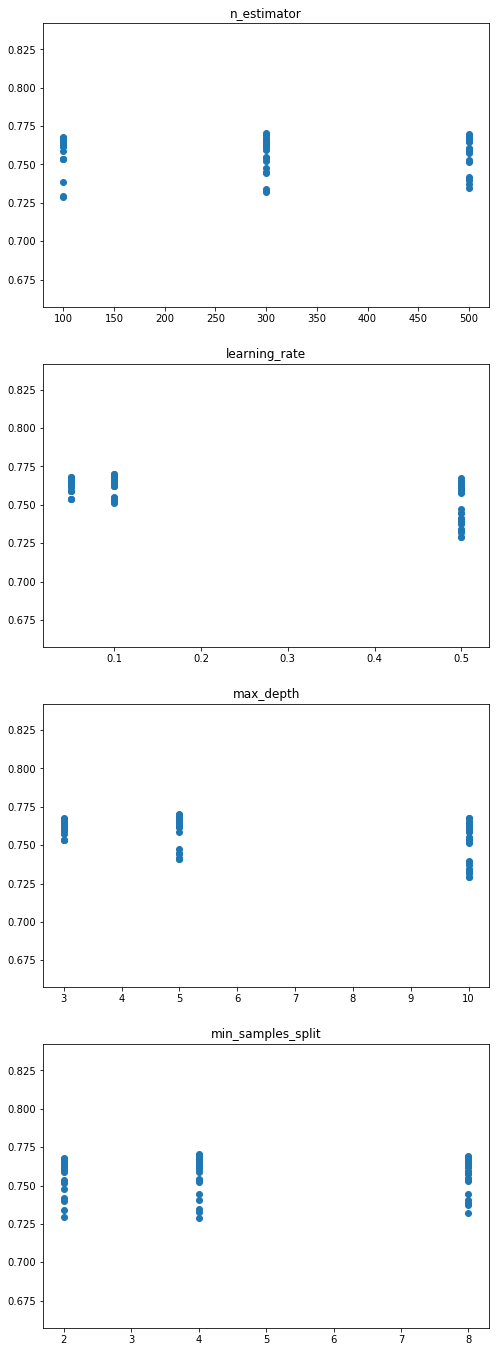

In [364]:
#Plot all the results (these plots will make more sense with 70 models or so)

params = ['n_estimator', 'learning_rate', 'max_depth', 'min_samples_split']

fig, axes = plt.subplots(nrows=len(params), ncols=1)
y = model_specs['F-Score']

for i in range(len(params)):
    x = model_specs[params[i]]
    ax = axes[i]
    ax.set_title(params[i])
    ax.scatter(x, y)

plt.gcf().set_size_inches(8,24) 
plt.savefig('gbt_opt_plot.png')

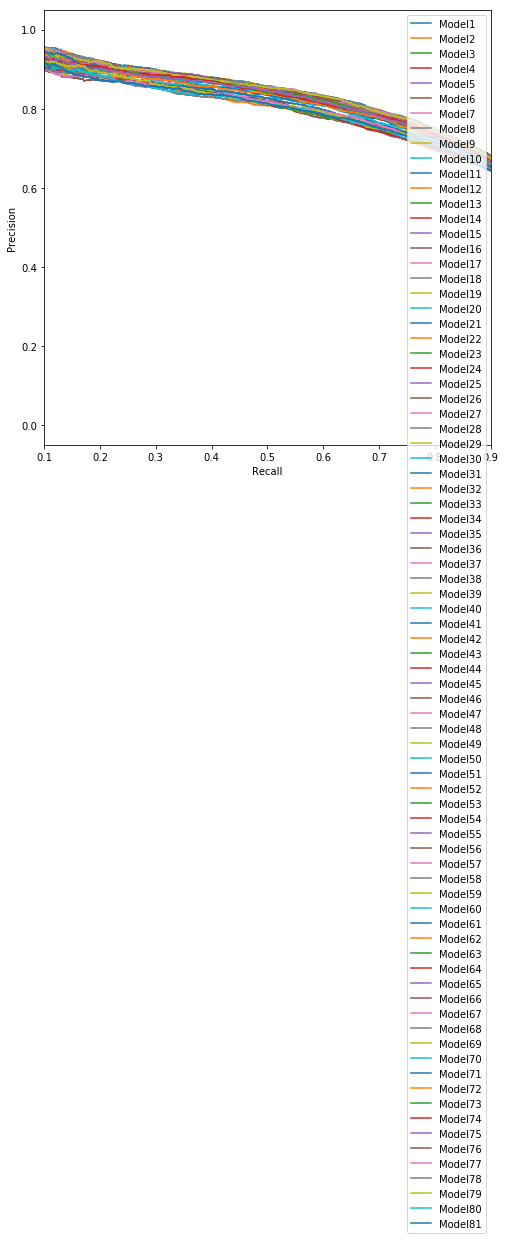

In [365]:
for model_num in list(model_specs['ModelID']):
    curve = precision_recall_curve(y_val, models_predict_prob[model_num][:,1])
    precision, recall, thresholds = curve
    line = pylab.plot(recall, precision, label = model_num)
    pylab.legend(loc='upper right')
    pylab.xlim(.1,.9)
    pylab.xlabel('Recall')
    pylab.ylabel('Precision')
    

plt.gcf().set_size_inches(8,8) 
plt.savefig('precision_recall_param_opt.png')
plt.show()

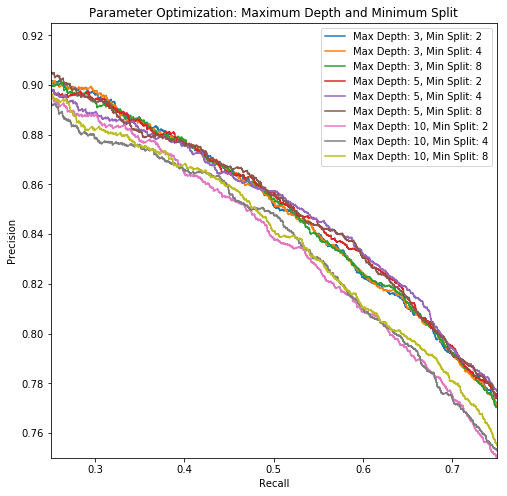

In [423]:
for model_num in list(model_specs[(model_specs['learning_rate']==0.1) & (model_specs['n_estimator']==300)]['ModelID']):
    curve = precision_recall_curve(y_val, models_predict_prob[model_num][:,1])
    precision, recall, thresholds = curve
    l = 'Max Depth: ' + str(model_specs.loc[model_num, 'max_depth']) + ', Min Split: ' + str(model_specs.loc[model_num, 'min_samples_split'])
    line = pylab.plot(recall, precision, label = l)
    pylab.legend(loc='upper right')
    pylab.xlim(.25,.75)
    pylab.ylim(.75, .925)
    pylab.xlabel('Recall')
    pylab.ylabel('Precision')
    pylab.title('Parameter Optimization: Maximum Depth and Minimum Split')
    
plt.gcf().set_size_inches(8,8) 
plt.savefig('precision_recall_param_opt_depth_split.png')
plt.show()

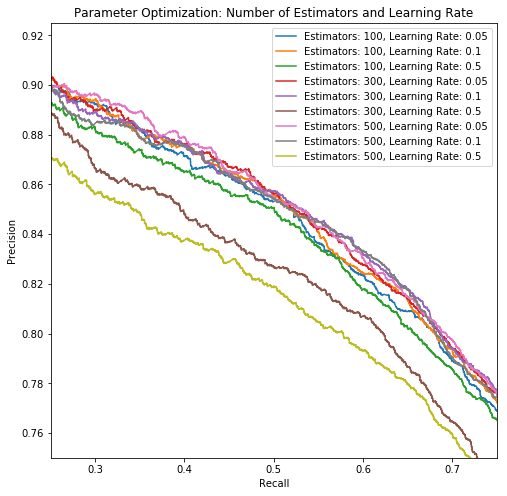

In [422]:
for model_num in list(model_specs[(model_specs['max_depth']==5) & (model_specs['min_samples_split']==4)]['ModelID']):
    curve = precision_recall_curve(y_val, models_predict_prob[model_num][:,1])
    precision, recall, thresholds = curve
    l = 'Estimators: ' + str(model_specs.loc[model_num, 'n_estimator']) +\
    ', Learning Rate: ' + str(model_specs.loc[model_num, 'learning_rate'])
    line = pylab.plot(recall, precision, label = l)
    pylab.legend(loc='upper right')
    pylab.xlim(.25,.75)
    pylab.ylim(.75, .925)
    pylab.xlabel('Recall')
    pylab.ylabel('Precision')
    pylab.title('Parameter Optimization: Number of Estimators and Learning Rate')
    
plt.gcf().set_size_inches(8,8) 
plt.savefig('precision_recall_param_opt_est_lr.png')
plt.show()

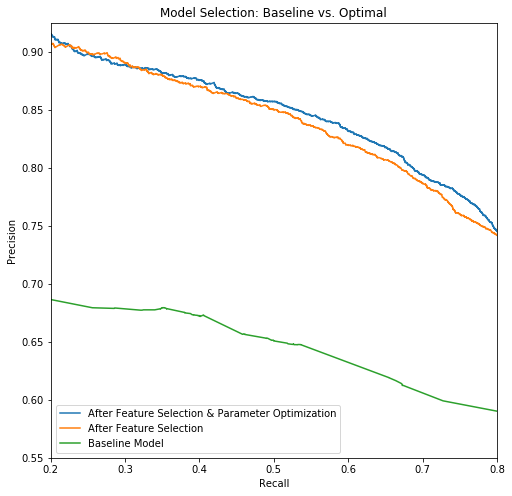

In [428]:
curve = precision_recall_curve(y_val, models_predict_prob['Model41'][:,1])
precision, recall, thresholds = curve
line = pylab.plot(recall, precision, label = 'After Feature Selection & Parameter Optimization')

curve = precision_recall_curve(y_val, models_predict_prob['Model10'][:,1])
precision, recall, thresholds = curve
line = pylab.plot(recall, precision, label = 'After Feature Selection')

baseline_precision = np.load('precision_baseline.npy')
baseline_recall = np.load('recall_baseline.npy')

line = pylab.plot(baseline_recall, baseline_precision, label = 'Baseline Model')

pylab.legend(loc='lower left')
pylab.xlim(.2,.8)
pylab.ylim(.55, .925)
pylab.xlabel('Recall')
pylab.ylabel('Precision')
pylab.title('Model Selection: Baseline vs. Optimal')
    
plt.gcf().set_size_inches(8,8) 
plt.savefig('precision_recall_baseline_v_optimal.png')
plt.show()

### Confusion Matrix and Risk CSV

In [432]:
gbt_cm = sklearn.metrics.confusion_matrix(y_val,models_predict_val['Model41'])
gbt_cm    #add cm.to_latex?
pd.DataFrame(gbt_cm).to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &     0 &     1 \\\\\n\\midrule\n0 &  3909 &  1387 \\\\\n1 &  1260 &  4438 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [480]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')
test = pd.read_csv('test.csv')

In [481]:
#target variable of rearrest in 5 years
og_X_train, og_y_train = pe.create_target(train, years = 5)
og_X_val, og_y_val = pe.create_target(val, years = 5)
og_X_test, og_y_test = pe.create_target(test, years = 5)

In [482]:
val_predict_proba = models_fit['Model41'].predict_proba(X_val)

test_predict_proba = models_fit['Model41'].predict_proba(X_test)

train_predict_proba = models_fit['Model41'].predict_proba(X_train)

In [490]:
pd.concat([og_X_train['BOFI_NBR'], pd.Series(train_predict_proba[:,1])], axis=0).to_csv('train_risk.csv')

In [491]:
pd.concat([og_X_val['BOFI_NBR'], pd.Series(val_predict_proba[:,1])], axis=0).to_csv('val_risk.csv')

In [492]:
pd.concat([og_X_test['BOFI_NBR'], pd.Series(test_predict_proba[:,1])], axis=0).to_csv('test_risk.csv')

### Error Analysis (Perform on the best model)

In [370]:
preds_to_analyze = models_predict_val['Model41']

np.save('pred_val_5yr_gbt_optimal.npy', preds_to_analyze)

In [382]:
val_data = pd.read_csv('data_val.csv', encoding = "ISO-8859-1", low_memory=False, index_col=0)

In [402]:
numeric = ['NEXT_ARREST_TIME','CRIMINAL_FLAG','FINAL_DETENTION_FLAG','HABITUAL_OFFENDER_FLAG',\
           'INITIAL_DETENTION_FLAG','JUVENILE_FLAG','TOT_NUM_DEF','MULTIPLE_DEF_FLAG','SCREENING_DAYS',\
           'ARREST_DATE_y','SCREENING_DISP_DATE_y',\
           'SCREENING_DISP_DATE_m', 'AGE', 'ARREST_TO_SCREEN']

numeric_exc_binary = ['NEXT_ARREST_TIME','SCREENING_DAYS',\
           'ARREST_DATE_y','SCREENING_DISP_DATE_y',\
           'SCREENING_DISP_DATE_m', 'AGE']

categorical =['CHARGE_CLASS', 'CHARGE_TYPE',\
       'PARTY', 'RACE', 'SADA_RACE','SEX','SADA_SEX']

In [399]:
val_error = ea.Error_Analysis('5_yr_gbt_optimal', 'data_val.csv', 'pred_val_5yr_gbt_optimal.npy')

val_error.create_err_analysis_df(5)

val_error.divide_preds()

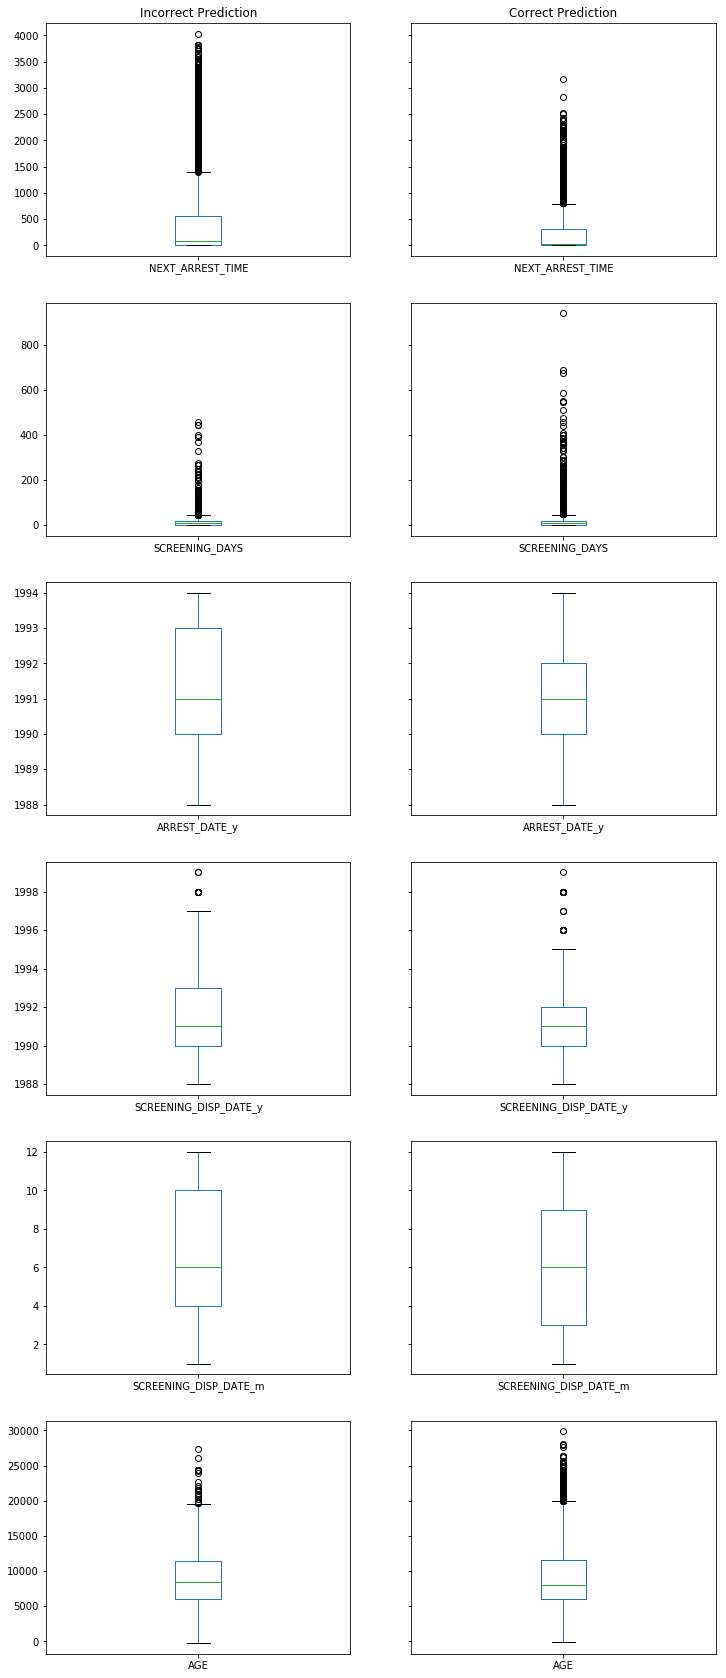

In [403]:
val_error.plot_boxplots(numeric_exc_binary)

In [405]:
val_error.mean_comparison(numeric)

val_error.correlation(numeric)

val_error.make_cat_breakdowns(categorical)

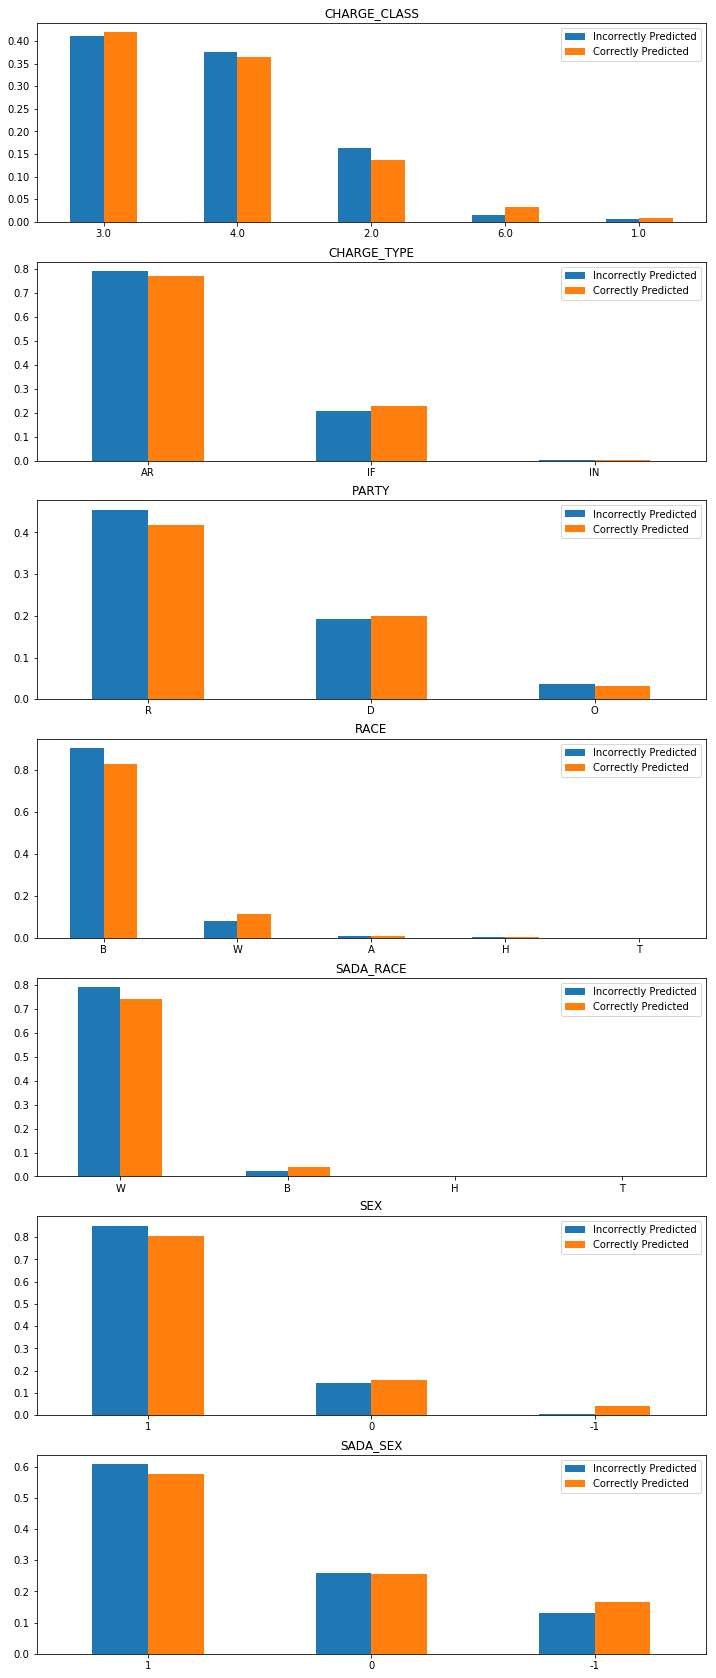

In [408]:
val_error.plot_cat_breakdowns()

# Random Forest

### Default Parameters

In [148]:
rf_clf =  RandomForestClassifier()
rf_clf = rf_clf.fit(X_train,y_train)

rf_pred_train = rf_clf.predict(X_train)
rf_pred_val = rf_clf.predict(X_val)

In [ ]:
RandomForestClassifier()

In [149]:
#a rf ccuracy
rf_accu_train = sklearn.metrics.accuracy_score(y_train,rf_pred_train)
rf_accu_test = sklearn.metrics.accuracy_score(y_val,rf_pred_val)

print("Accuracy on Training Dataset: {}".format(rf_accu_train))
print("Accuracy on Val Dataset: {}".format(rf_accu_test))

Accuracy on Training Dataset: 0.980064926878467
Accuracy on Val Dataset: 0.6518121651433975


In [12]:
rf_precision = sklearn.metrics.precision_score(y_val,rf_pred_val)
rf_recall = sklearn.metrics.recall_score(y_val,rf_pred_val)
rf_f_score = sklearn.metrics.f1_score(y_val,rf_pred_val)

print("Precision: {}".format(rf_precision))
print("Recall: {}".format(rf_recall))
print("F-Score: {}".format(rf_f_score))

Precision: 0.5926903553299493
Recall: 0.4508108108108108
F-Score: 0.5121052631578948


In [13]:
#confusion matrix for val set
rf_cm = sklearn.metrics.confusion_matrix(y_val,rf_pred_val)
rf_cm    #add cm.to_latex?

array([[7384, 2006],
       [3556, 2919]])

### Parameter Optimization

In [206]:
#Reduced Number of Options for Run-times

n_estimators = [10, 50, 100]
max_features = ['sqrt','log2']
max_depths = [8, 10, 12]
min_samples_splits = [2, 4, 8]

In [207]:
model_specs_rf = pd.DataFrame(list(product(n_estimators, max_features, max_depths, min_samples_splits)),\
             columns=['n_estimator', 'max_features', 'max_depth', 'min_samples_split'])

model_specs_rf['ModelID'] = range(1, len(model_specs_rf)+1)

model_specs_rf['ModelID'] = 'Model' + model_specs_rf['ModelID'].astype(str)

model_specs_rf.head()

,n_estimator,max_features,max_depth,min_samples_split,ModelID
0,10,sqrt,4,2,Model1
1,10,sqrt,4,4,Model2
2,10,sqrt,4,8,Model3
3,10,sqrt,8,2,Model4
4,10,sqrt,8,4,Model5


In [208]:
models_rf = {}

for i in range(len(model_specs_rf)):
    models_rf[model_specs_rf.iloc[i,:]['ModelID']] = \
    RandomForestClassifier(n_estimators = int(model_specs_rf.iloc[i,:]['n_estimator']),\
                               max_features = model_specs_rf.iloc[i,:]['max_features'],\
                               max_depth = model_specs_rf.iloc[i,:]['max_depth'],\
                               min_samples_split = int(model_specs_rf.iloc[i,:]['min_samples_split'])
                              )

In [210]:
models_fit_rf = {k: v.fit(X_train,y_train) for k, v in models_rf.items()}

In [211]:
models_predict_val_rf = {k: v.predict(X_val) for k, v in models_fit_rf.items()}

In [212]:
model_specs_rf.index = model_specs_rf['ModelID']

for model_num in list(model_specs_rf['ModelID']):
    model_specs_rf.loc[model_num, 'Val Accuracy'] = \
    sklearn.metrics.accuracy_score(y_val, models_predict_val_rf[model_num])

for model_num in list(model_specs_rf['ModelID']):
    model_specs_rf.loc[model_num, 'Precision'] = \
    sklearn.metrics.precision_score(y_val, models_predict_val_rf[model_num])

for model_num in list(model_specs_rf['ModelID']):
    model_specs_rf.loc[model_num, 'Recall'] = \
    sklearn.metrics.recall_score(y_val, models_predict_val_rf[model_num])

for model_num in list(model_specs_rf['ModelID']):
    model_specs_rf.loc[model_num, 'F-Score'] = \
    sklearn.metrics.f1_score(y_val, models_predict_val_rf[model_num])

/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [214]:
#creates a numeric version of the max_features parameter

model_specs_rf['max_features_number']= \
np.where(model_specs_rf['max_features']=='sqrt', math.sqrt(X_train.shape[1]), math.log(X_train.shape[1],2))

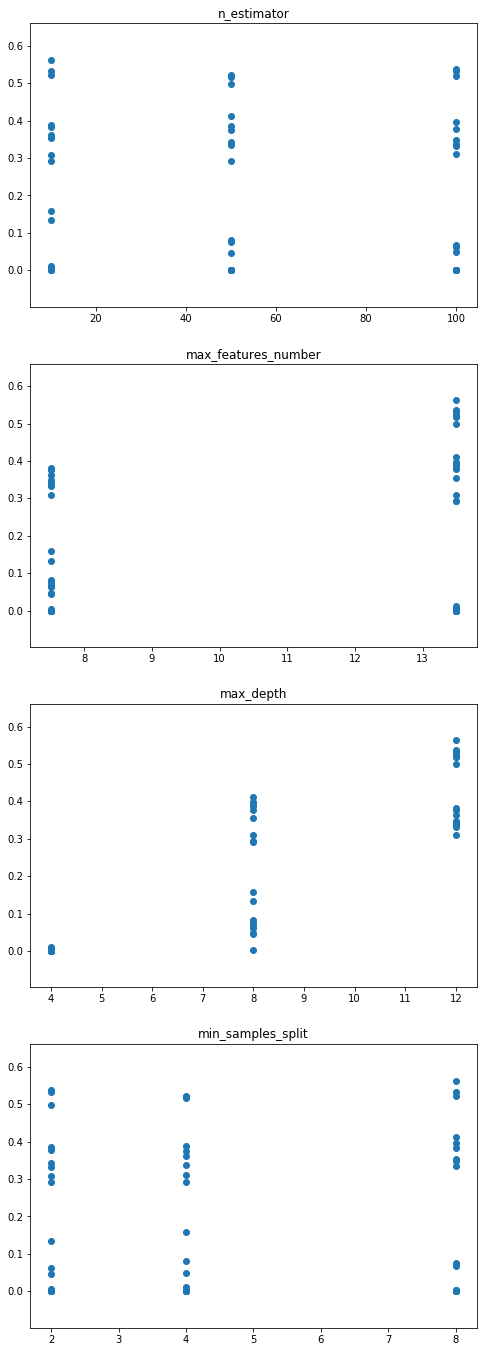

In [215]:
#Plot all the results

params = ['n_estimator', 'max_features_number', 'max_depth', 'min_samples_split']

fig, axes = plt.subplots(nrows=len(params), ncols=1)
y = model_specs_rf['F-Score']

for i in range(len(params)):
    x = model_specs_rf[params[i]]
    ax = axes[i]
    ax.set_title(params[i])
    ax.scatter(x, y)

plt.gcf().set_size_inches(8,24) 
matplotlib.pyplot.show()